# Feature extraction and anlysis

<font size="4">
Once the $CB_{agg}$ are extracted from the matrix, we can define various morphological features to describe them
    
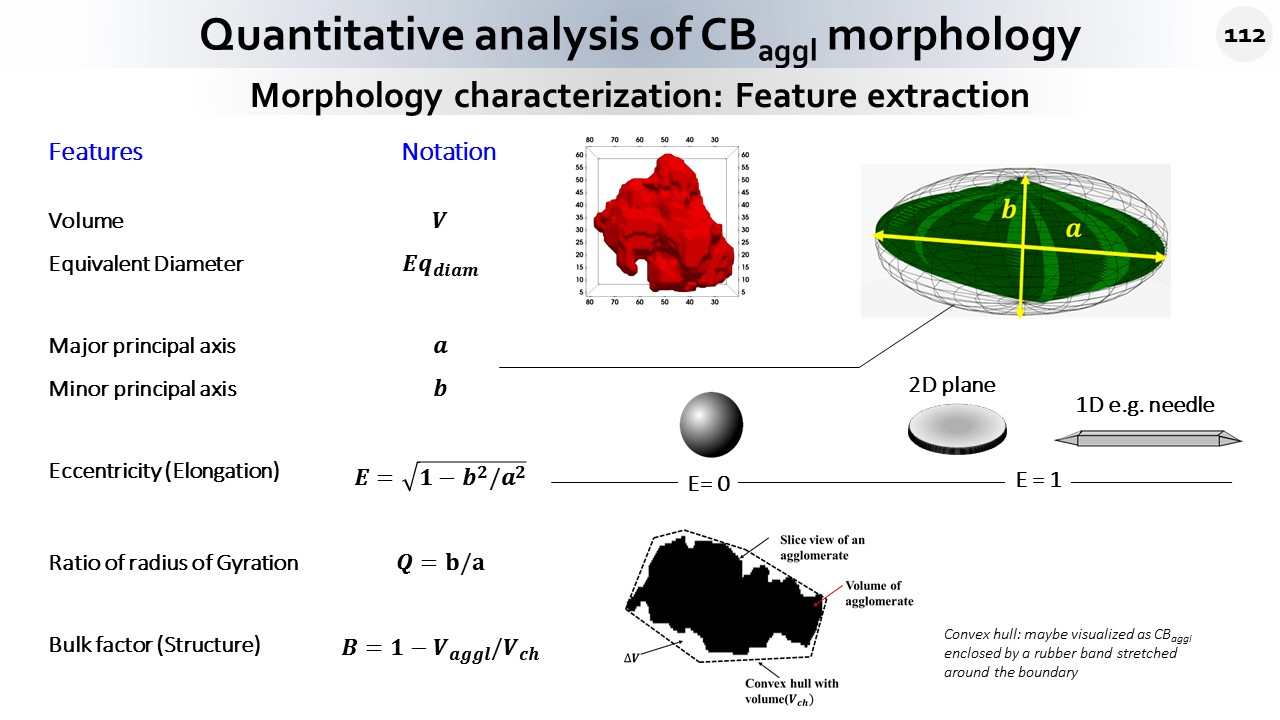


<br>
    
The principal library library used for morphological ferature extraction
***
`
from skimage.measure import label, regionprops
`
***
    
https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

In [25]:
%matplotlib inline
from skimage.measure import label, regionprops # main library to extract information
from skimage import img_as_float, img_as_ubyte, morphology, io, segmentation
import pandas as pd
import numpy as np
from scipy import stats
from math import sqrt,pi

#plotting libraries
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
import seaborn as sns


# Morphology feature extraction function

In [28]:

def features(image,res):
    # image: 3D stack image which is binarized.
    # res: voxel resolution 
    # clean = morphology.remove_small_objects(image == 255, 125), use 255 if the greyscale values are 0-255, use 1 if it is between 0-1
    # labelling the agglomerates
    
    image_border_removed=segmentation.clear_border(image) # to remove the artifacts touching the borders
    clean = morphology.remove_small_objects(image_border_removed == 255, 125) # extract agglomerates with size greater than 125 voxel.
    stack_label = label(clean,connectivity=3,background=0) # connectivity = 3, implies 26 neighbhors 
    regions=regionprops(stack_label) # labeling the agglomerates
    label_number=np.arange(np.max(stack_label)+1) # extracting the label numbers of agglomerates (optional)
    print(label_number) #(optional)
    
    # Variable for morphological features
    volume=[]
    eq_diam=[]
    maj_length=[]
    min_length=[]
    centroid=[]
    bulk=[] # structure bulk
    
    #Orientation variables
    theta=[]
    alpha=[]
    beta=[]
    tensor=[]


    # for loop for going through each labels and extracting each features
    for props in regions:
        volume.append(props.area) # Eventhough it is written area, value generated will be volume.(nomenclature in library)
        eq_diam.append(props.equivalent_diameter)# Equivalent diameter
        maj_length.append(props.major_axis_length) # major principle axis
        min_length.append(props.minor_axis_length) # minor principle axis
        centroid.append(props.centroid) # centroid of each agglomerates
        bulk.append(props.convex_area)# volume of the convex hull around the agglomerate
        tensor.append(props.inertia_tensor) # inertia tensor for each agglomerate


    # orientation of agglomerates. 
    # Based on the inertia tensor one can generate eigen vector corresponding to each agglomerate
    # With eigen vector representing the orientation, we can deduce angles
    # Definition of angles are given below
    for i in range(len(tensor)):
        evals,evecs=np.linalg.eig(tensor[i]) # extracting eigen values and eigen vectors
        sort_indices = np.argsort(evals)[::-1]
        z_v1,y_v1, x_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        theta.append(np.arctan((sqrt(y_v1**2+x_v1**2))/(z_v1)))
        alpha.append(np.arccos(x_v1/(sqrt(z_v1**2+y_v1**2+x_v1**2))))
        beta.append(np.arccos(y_v1/(sqrt(z_v1**2+y_v1**2+x_v1**2))))
    
    # organizing all the datas in a dataframe
    Data = pd.DataFrame(np.column_stack((volume,
                                           eq_diam,
                                           bulk,
                                           min_length,
                                           maj_length,
                                           theta,
                                           alpha,
                                           beta,
                                           centroid)))
    # name of each column is specified
    df=Data.rename(columns={0:"V",
                                 1:"Eq_diam",
                                 2:"B",
                                 3:"b",
                                 4:"a",
                                 5:"theta",
                                 6:"alpha",
                                 7:"beta",
                                 8:"centroid_z",
                                 9:"centroid_y",
                                 10:"centroid_x"})

    
   
    B=1-df.V/df.B
    df['B']= B # redifing the structure values
    
    df.insert(3, "E",(1-(df.b/df.a)**2)**0.5) # inserting the eccentricity values
    df.insert(5, "Q", df.b/df.a) # ratio of minor and major principle axis
    
    df['V']=df['V']*res**3 # converting voxel to µm
    df['Eq_diam']=df['Eq_diam']*res
    df['b']=df['b']*res
    df['a']=df['a']*res
    
    return df

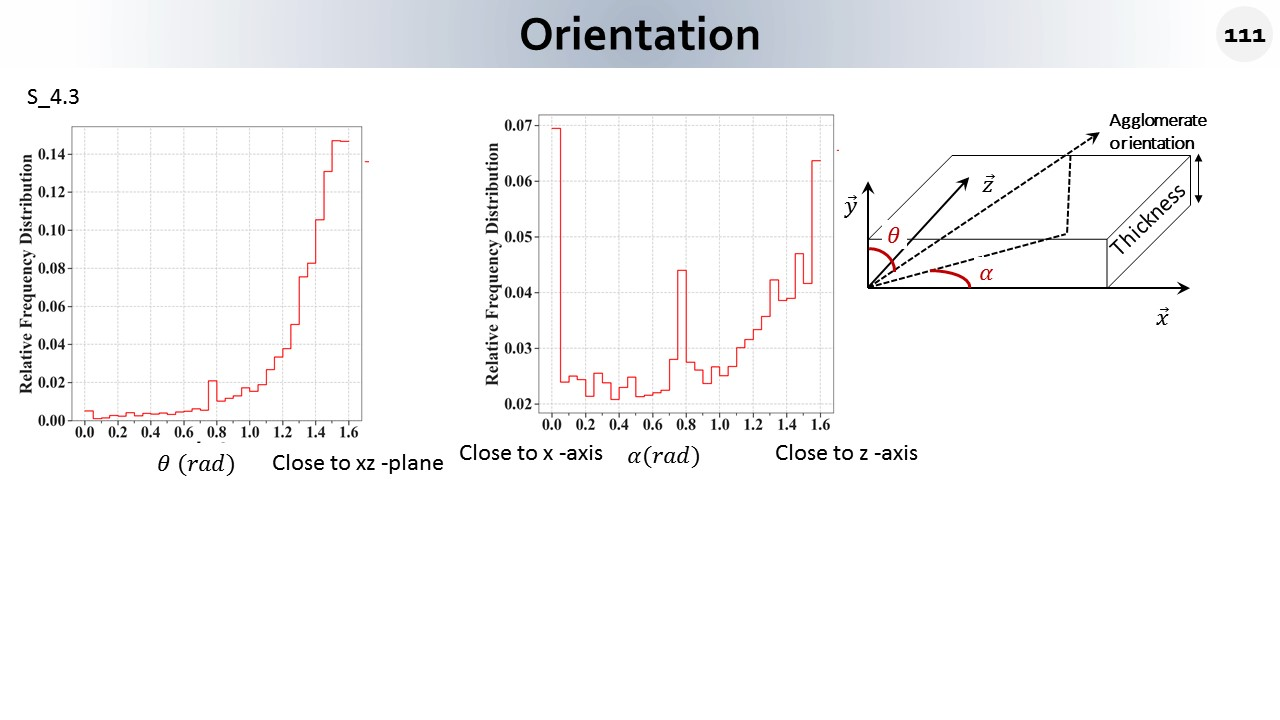

In [29]:
stack=io.imread('./clean.tif')
df=features(stack,1)

[0 1 2 3 4 5 6 7 8]


In [24]:
df

,V,Eq_diam,B,E,b,a,Q,theta,alpha,beta,centroid_z,centroid_y,centroid_x
0,240.0,7.710293,0.055118,0.555651,9.008661,10.835330,0.831415,-1.482773,0.220648,1.772594,3.904167,15.329167,197.712500
1,158.0,6.707379,0.065089,0.651257,7.619879,10.041250,0.758858,-1.526463,0.326092,1.893639,4.810127,33.120253,287.056962
2,136.0,6.380383,0.068493,0.413115,7.732847,8.491300,0.910679,-1.027822,0.917071,2.217620,3.786765,118.522059,350.433824
3,258.0,7.898423,0.033708,0.555792,9.239035,11.113678,0.831321,1.321386,0.339526,1.796286,4.341085,327.244186,215.364341
4,131.0,6.301214,0.196319,0.745439,6.949416,10.425578,0.666574,-1.369835,0.726558,2.256996,3.572519,367.091603,364.557252
5,129.0,6.268982,0.015267,0.721654,6.890177,9.953253,0.692254,1.423523,0.157113,1.516464,3.395349,378.558140,366.209302
6,163.0,6.777398,0.046784,0.634779,8.128856,10.520154,0.772694,-0.927974,0.643661,1.542425,5.478528,26.975460,143.184049
7,132.0,6.317207,0.000000,0.856696,6.395355,12.398391,0.515821,0.938040,2.508721,1.581252,5.000000,315.500000,343.500000
